In [4]:
import duckdb
import pandas as pd
import numpy as np
from sandbox_generator import createSandbox

In [5]:
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [258]:
createSandbox()

'sandbox'

In [259]:
con = duckdb.connect('data/exploitation.db')
con.execute("show tables").fetchall()

[('houses',), ('sandbox',)]

In [260]:
df = con.execute("select * from sandbox").df()

In [261]:
def numeric_description(df):
    df_numeric_description = df.describe().transpose()
    df_numeric_description["missings"] = len(df) - df_numeric_description["count"]
    #df.shape #len df
    df_numeric_description["missing ratio (%)"] = round(df_numeric_description["missings"]*100/len(df), 2)
    return df_numeric_description.drop(['count'], axis=1)


In [262]:
def description_categorical(df):
    n = len(df)
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cat_dict = dict({"": [],"#Levels":[],"Max Freq (Abs,%)":[],"Min Freq (Abs,%)":[],"#Unknows":[],"Unknows (%)":[]})

    for i,t in columns:

        if t != "object":
            continue

        freq = dict(df[i].apply(lambda x: str(x)).value_counts())
        freq_list = [(y,x) for x,y in freq.items()]

        max_freq = max(freq_list)[1] + " (" + str(max(freq_list)[0]) 
        max_freq += (", " + str(round(max(freq_list)[0]*100/n,2)) + ")")

        min_freq = min(freq_list)[1] + " (" + str(min(freq_list)[0]) 
        min_freq += (", " + str(round(min(freq_list)[0]*100/n,2)) + ")")

        cat_dict[""].append(i)
        cat_dict["#Levels"].append(len(freq_list))
        cat_dict["Max Freq (Abs,%)"].append(max_freq)
        cat_dict["Min Freq (Abs,%)"].append(min_freq)
        
        if "unknow" in freq:
            cat_dict["#Unknows"].append(freq["unknow"])
            cat_dict["Unknows (%)"].append(round(freq["unknow"]*100 /n,2))

        else:
            cat_dict["#Unknows"].append(0)
            cat_dict["Unknows (%)"].append(0)

    return pd.DataFrame(cat_dict)


In [263]:
def barplot(df,top=10,freq=False):
    n = len(df)
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    

    for i,t in columns:

        if t != "object":
            continue

        if freq:
            df[i].value_counts().head(top).apply(lambda x : x/n).plot( kind='bar')
        else:
            df[i].value_counts().head(top).plot( kind='bar')
        plt.title(i)
        plt.show()

In [264]:
def hist(df, bins=50):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    for i,t in columnss:

        if t != "float64" and t != "int32":
            continue

        df[i].hist(bins=min(bins,len(df[i].unique())))
        plt.title(i)
        plt.show()

# input: dataframe
# output: box plot of the numerical features from the dataframe
def boxplot(df):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    for i,t in columnss:

        if t != "float64" and t != "int32":
            continue

        df.loc[:, [i]].boxplot();
        plt.title(i)
        plt.show()

In [265]:
def log_transformation(df,cols=[]):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cols = set(cols)
    for i,t in columnss:

        if (t != "float64" and t != "int32") or i not in cols:
            continue
            
        print(i)
        df[i] = df[i].map(lambda x: np.log(x+1))

In [266]:
def outliers_cutpoints(df,col = "price",alpha=0.01):
  var = np.sort(df[col].to_numpy())
  var = var[~np.isnan(var)]
  n = var.size
  k = round(n*alpha/2)
  bot = k
  top = n-1-k

  return (var[bot],var[top])

In [267]:
def clean_outliers(df,cols=[]):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cols = set(cols)
    for i,t in columnss:

        if (t != "float64" and t != "int32") or i not in cols:
            continue
            
        print(i)
        (bot, top) = outliers_cutpoints(df,col = i,alpha=0.01)
        df[i] = df[i].map(lambda x: x if x >= bot and x<= top else np.nan)

In [268]:
numeric_description(df)

,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
id,7.040977e+09,8.804238e+06,7.003808e+09,7.035971e+09,7.043316e+09,7.048427e+09,7.051292e+09,0.0,0.00
price,8.906761e+03,4.485181e+06,1.000000e+00,8.100000e+02,1.040000e+03,1.395000e+03,2.768307e+09,1867.0,0.49
sqfeet,1.059535e+03,1.922083e+04,1.000000e+00,7.500000e+02,9.490000e+02,1.150000e+03,8.388607e+06,736.0,0.19
beds,1.904105e+00,3.503271e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.100000e+03,0.0,0.00
baths,1.480047e+00,6.175018e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.500000e+01,0.0,0.00
lat,3.723394e+01,5.546181e+00,-4.353330e+01,3.345570e+01,3.764790e+01,4.113910e+01,1.020360e+02,0.0,0.00
long,-9.270041e+01,1.653239e+01,-1.638940e+02,-1.007750e+02,-8.773820e+01,-8.117960e+01,1.726330e+02,0.0,0.00
num_hospitals,1.603495e+03,2.760014e+03,0.000000e+00,1.040000e+02,6.100000e+02,1.820000e+03,2.633200e+04,0.0,0.00
num_beds,2.711212e+05,5.236006e+05,9.000000e+00,1.565700e+04,9.218800e+04,2.955120e+05,7.407010e+06,525.0,0.14
hospital_type_general,9.559108e+02,1.649668e+03,0.000000e+00,6.200000e+01,3.600000e+02,1.080000e+03,1.634400e+04,0.0,0.00


In [269]:
description_categorical(df)

,,#Levels,"Max Freq (Abs,%)","Min Freq (Abs,%)",#Unknows,Unknows (%)
0,url,382909,https://zanesville.craigslist.org/apa/d/zanesv...,https://abilene.craigslist.org/apa/d/2-br/7028...,0,0.00
1,region,404,"jacksonville (4242, 1.11)","kansas city (3, 0.0)",0,0.00
2,region_url,413,"https://fredericksburg.craigslist.org (2744, 0...","https://bigbend.craigslist.org (9, 0.0)",0,0.00
3,type,12,"apartment (316613, 82.69)","assisted living (2, 0.0)",0,0.00
4,cats_allowed,2,"Yes (278476, 72.73)","No (104433, 27.27)",0,0.00
5,dogs_allowed,2,"Yes (271138, 70.81)","No (111771, 29.19)",0,0.00
6,smoking_allowed,2,"Yes (280279, 73.2)","No (102630, 26.8)",0,0.00
7,wheelchair_access,2,"No (351426, 91.78)","Yes (31483, 8.22)",0,0.00
8,electric_vehicle_charge,2,"No (377982, 98.71)","Yes (4927, 1.29)",0,0.00
9,comes_furnished,2,"No (364654, 95.23)","Yes (18255, 4.77)",0,0.00


In [270]:
df = df.drop(["id", "url", "region_url", "image_url", "description"], axis=1)

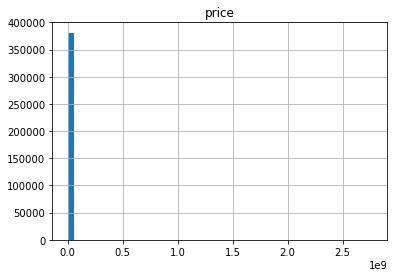

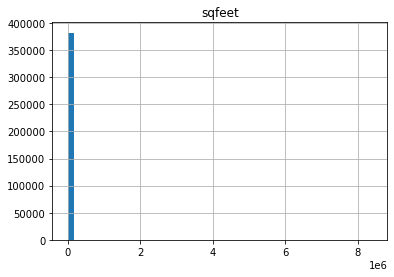

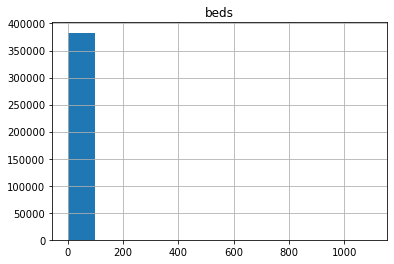

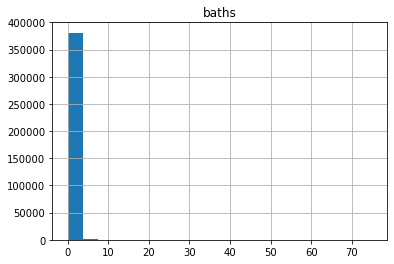

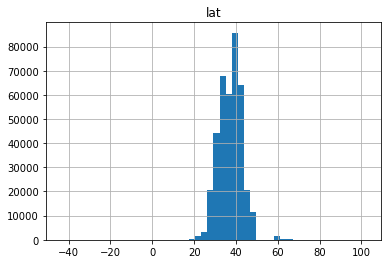

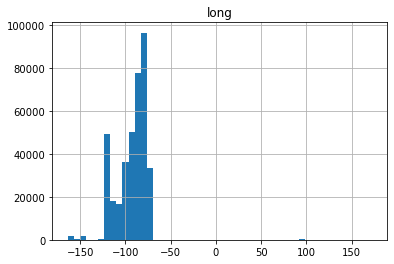

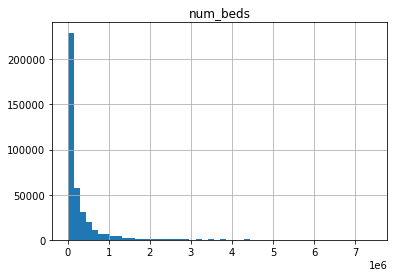

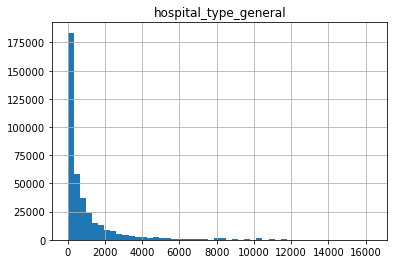

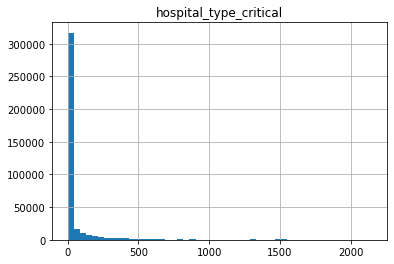

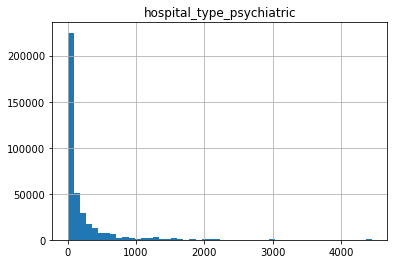

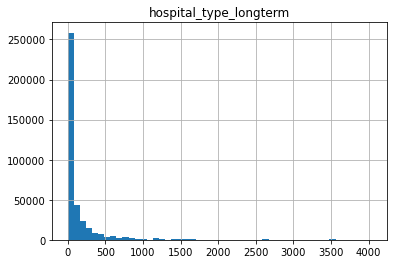

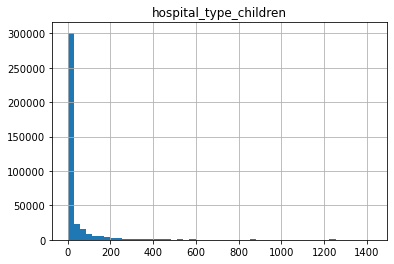

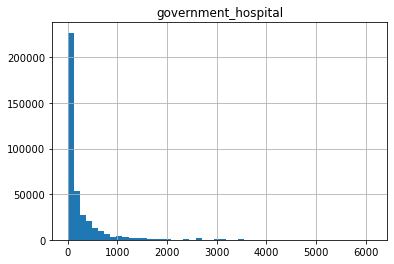

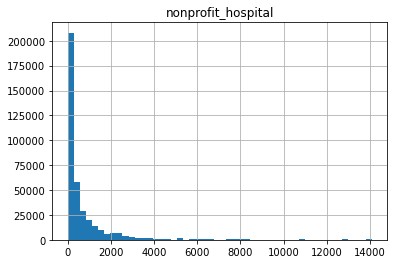

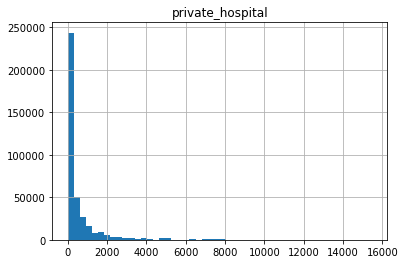

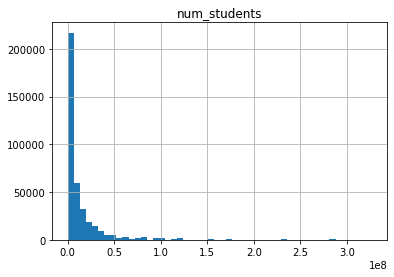

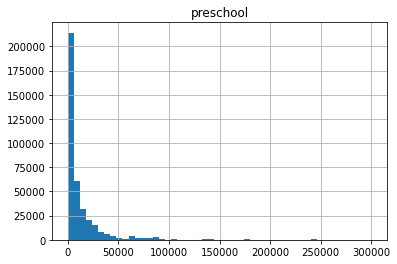

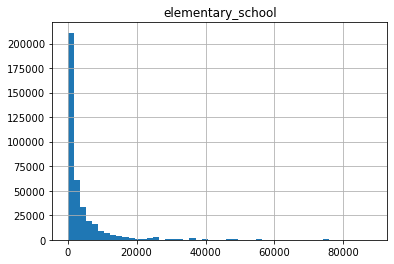

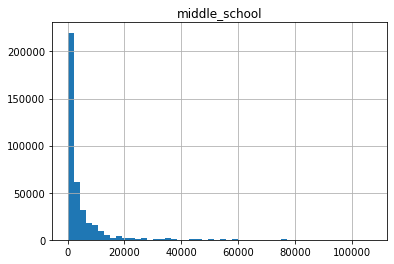

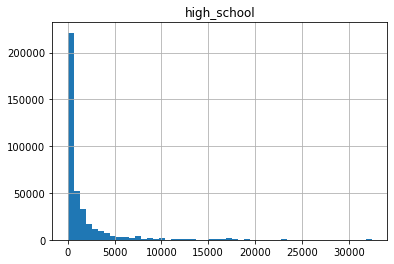

In [271]:
hist(df)

In [272]:
name_columns = list(df.columns)
types_columns = [str(x) for x in list(df.dtypes)]
i = 1
columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]

num_var = []
cat_var = []

for i,t in columns:
    if t == "object":
      cat_var.append(i)
    else:
      num_var.append(i)

print(cat_var)
print()
print(num_var)

['region', 'type', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options', 'state']

['price', 'sqfeet', 'beds', 'baths', 'lat', 'long', 'num_hospitals', 'num_beds', 'hospital_type_general', 'hospital_type_critical', 'hospital_type_psychiatric', 'hospital_type_longterm', 'hospital_type_children', 'government_hospital', 'nonprofit_hospital', 'private_hospital', 'num_schools', 'num_students', 'preschool', 'elementary_school', 'middle_school', 'high_school']


## Log transformations and clean outliers

In [273]:
num_cols = set(num_var) - set(["beds","baths","lat","long"])
log_transformation(df,cols=num_cols)


price
sqfeet
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school


In [274]:
num_cols = set(num_var) - set(["lat","long"])
clean_outliers(df,cols=num_cols)

price
sqfeet
beds
baths
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school


In [275]:
numeric_description(df)

,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
price,6.982588,0.402094,5.669881,6.704414,6.947937,7.241366,8.296796,5653.0,1.48
sqfeet,6.837999,0.333230,5.620401,6.621406,6.856462,7.044033,7.937732,4520.0,1.18
beds,1.889453,0.868944,0.000000,1.000000,2.000000,2.000000,5.000000,322.0,0.08
baths,1.475473,0.578576,0.000000,1.000000,1.000000,2.000000,4.000000,452.0,0.12
lat,37.233942,5.546181,-43.533300,33.455700,37.647900,41.139100,102.036000,0.0,0.00
long,-92.700412,16.532394,-163.894000,-100.775000,-87.738200,-81.179600,172.633000,0.0,0.00
num_hospitals,1603.495345,2760.014135,0.000000,104.000000,610.000000,1820.000000,26332.000000,0.0,0.00
num_beds,11.048577,2.043049,5.010635,9.684523,11.432225,12.580326,15.060759,4192.0,1.09
hospital_type_general,5.530275,1.930143,0.693147,4.158883,5.888878,6.979145,9.248503,2804.0,0.73
hospital_type_critical,1.180142,2.008555,0.000000,0.000000,0.000000,1.791759,7.180070,1684.0,0.44


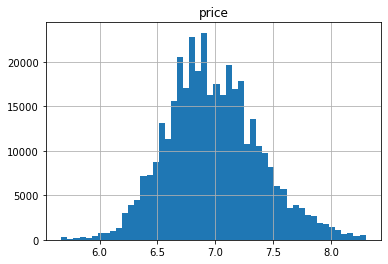

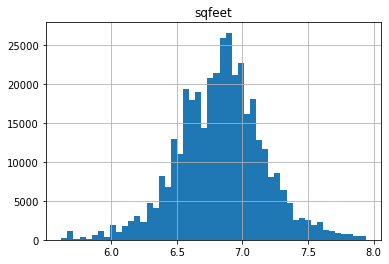

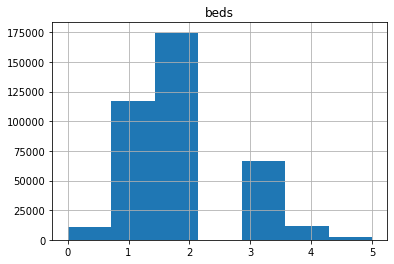

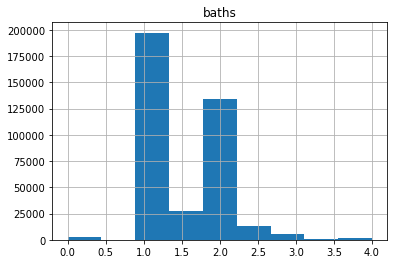

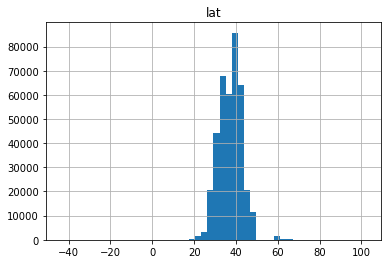

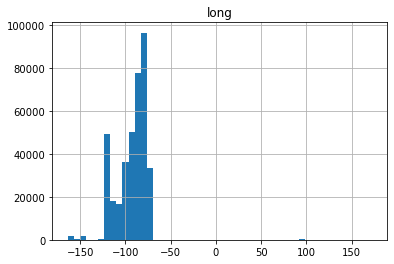

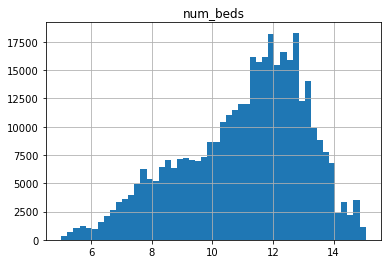

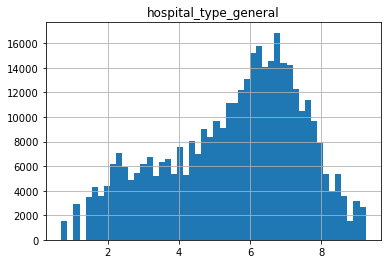

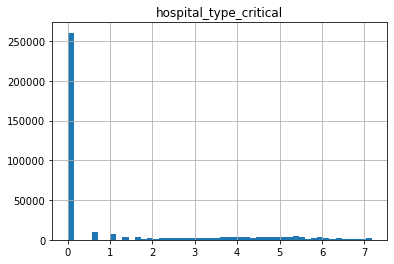

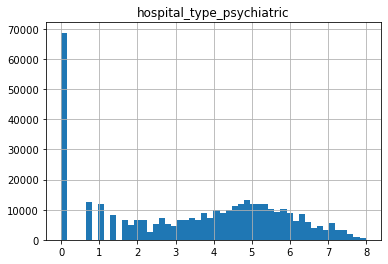

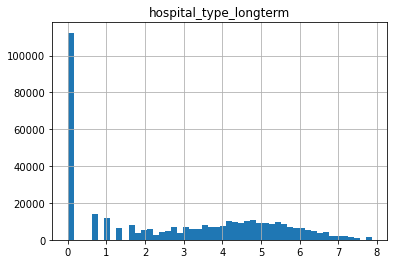

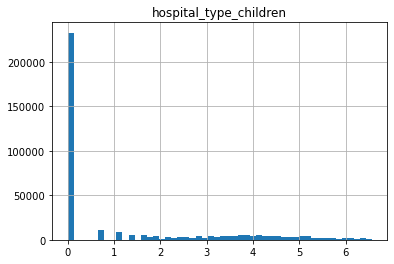

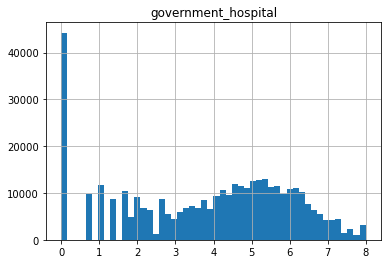

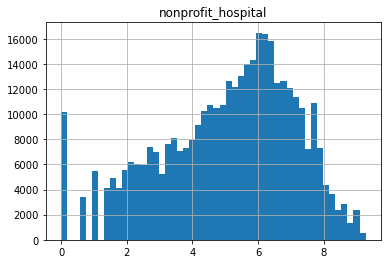

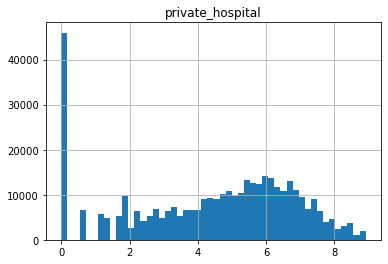

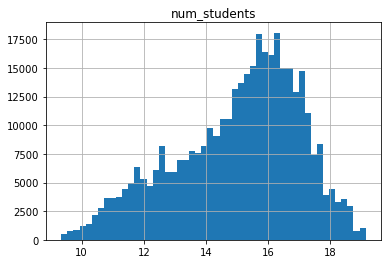

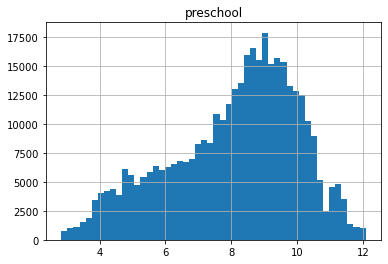

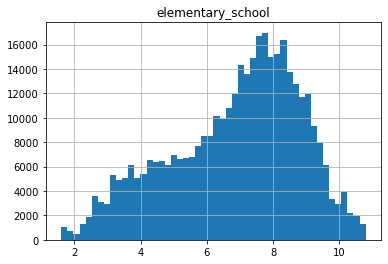

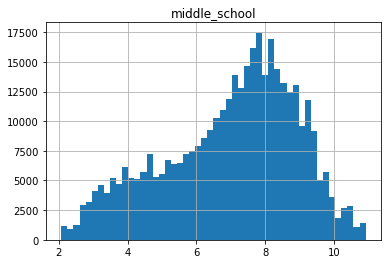

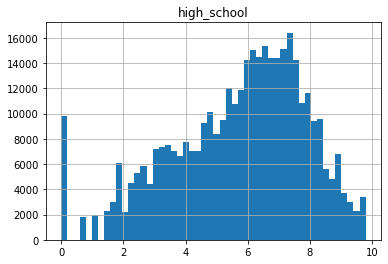

In [276]:
hist(df)

## imputation

In [277]:
df = df.dropna(subset=["price"])
print(df.shape[0])
df.describe()

377256


,price,sqfeet,beds,baths,lat,long,num_hospitals,num_beds,hospital_type_general,hospital_type_critical,...,hospital_type_children,government_hospital,nonprofit_hospital,private_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school
count,377256.000000,373286.000000,377017.000000,376937.000000,377256.000000,377256.000000,377256.00000,373131.000000,374489.000000,375572.000000,...,375472.000000,375825.000000,375564.000000,375552.000000,377256.000000,373484.000000,373808.000000,373961.000000,373697.000000,375472.000000
mean,6.982588,6.837565,1.886711,1.473067,37.243055,-92.599925,1614.36673,11.056982,5.537770,1.186035,...,1.324013,3.832411,5.069239,4.414205,23525.073465,15.023136,8.076816,6.880027,6.991608,5.705763
std,0.402094,0.330027,0.864243,0.574866,5.549730,16.474182,2771.38127,2.043553,1.931180,2.012496,...,1.932394,2.209969,2.067994,2.444933,44770.629883,2.011799,1.958233,1.961523,1.923500,2.187757
min,5.669881,5.620401,0.000000,0.000000,-43.533300,-163.894000,0.00000,5.010635,0.693147,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.347054,2.833213,1.609438,2.079442,0.000000
25%,6.704414,6.621406,1.000000,1.000000,33.454700,-99.464850,105.00000,9.700575,4.174387,0.000000,...,0.000000,1.945910,3.663562,2.639057,1578.000000,13.681781,6.781058,5.533389,5.686975,4.262680
50%,6.947937,6.855409,2.000000,1.000000,37.665800,-87.677700,616.00000,11.440366,5.899897,0.000000,...,0.000000,4.290459,5.416100,4.934474,8640.000000,15.406097,8.451267,7.247081,7.353082,6.079933
75%,7.241366,7.043160,2.000000,2.000000,41.152300,-81.165400,1836.00000,12.594307,6.985642,1.945910,...,2.833213,5.590987,6.603944,6.311735,25805.000000,16.519553,9.534234,8.350902,8.423322,7.339538
max,8.296796,7.937732,5.000000,4.000000,102.036000,172.633000,26332.00000,15.060759,9.248503,7.180070,...,6.572283,7.995980,9.285912,8.919587,536628.000000,19.130062,12.088139,10.789917,10.906525,9.801510


In [278]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

df_num = df.select_dtypes(include=np.number)
numeric_cols = df_num.columns

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
df_num = imp.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=numeric_cols)


[IterativeImputer] Completing matrix with shape (377256, 22)
[IterativeImputer] Ending imputation round 1/10, elapsed time 7.82
[IterativeImputer] Change: 21.208330958515702, scaled tolerance: 536.628 
[IterativeImputer] Early stopping criterion reached.


In [279]:
print(type(df_num))

for i in numeric_cols:
    df.loc[:,i] = df_num.loc[:,i]
print(df.shape[0])
numeric_description(df)

<class 'pandas.core.frame.DataFrame'>
377256


,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
price,6.982630,0.402055,5.669881,6.704414,6.947937,7.241366,8.296796,5552.0,1.47
sqfeet,6.839024,0.333168,5.620401,6.621406,6.855409,7.044033,8.269423,5552.0,1.47
beds,1.886913,0.864584,0.000000,1.000000,2.000000,2.000000,5.000000,5552.0,1.47
baths,1.473701,0.575037,0.000000,1.000000,1.000000,2.000000,4.000000,5552.0,1.47
lat,37.238571,5.549565,-43.533300,33.452600,37.664500,41.145700,102.036000,5552.0,1.47
long,-92.599530,16.474343,-163.894000,-99.478100,-87.675900,-81.164600,172.633000,5552.0,1.47
num_hospitals,1615.033150,2770.452266,0.000000,105.000000,616.000000,1836.000000,26332.000000,5552.0,1.47
num_beds,11.048634,2.056968,5.010635,9.680855,11.437782,12.594307,15.060759,5552.0,1.47
hospital_type_general,5.534925,1.935906,0.256193,4.158883,5.899897,6.985642,9.554229,5552.0,1.47
hospital_type_critical,1.181248,2.015763,-2.668672,0.000000,0.000000,1.945910,7.180070,5552.0,1.47


## Transformations

<AxesSubplot:>

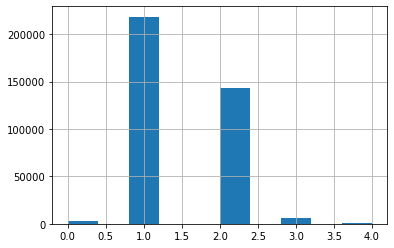

In [280]:
df["N_baths"] = df["baths"].apply(np.floor)
df["N_baths"].hist()

In [281]:
#df["half_baths"] = "Yes" if 0 < df["baths"] - df["N_baths"].item() else "No"
df["half_baths"] =  (df["baths"] - df["N_baths"]).apply(lambda x:"Yes" if 0 < x else "No") 


In [288]:
# half_baths,hospital_type_critical, hospital_type_longterm, hospital_type_children

df["b_hospital_type_critical"] = df["hospital_type_critical"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_hospital_type_longterm"] = df["hospital_type_longterm"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_hospital_type_children"] = df["hospital_type_children"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_type"] = df["type"].apply(lambda x:"Apartment" if "apartment" == x else "No-Apartment")



In [283]:
def equal_split(vector, k):
    n = len(vector)
    vec = sorted(list(vector))
    cuts = []
    for i in range(1,k):
        j = round((n+1)*i/k)
        cuts.append(vec[j])

    return cuts


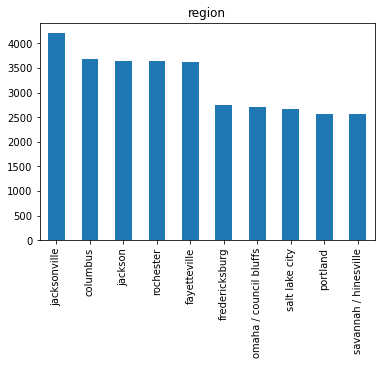

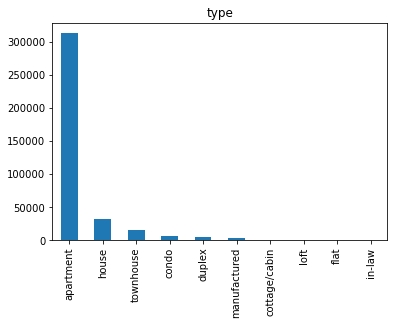

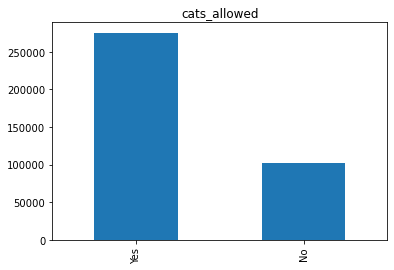

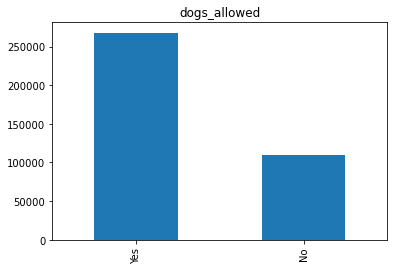

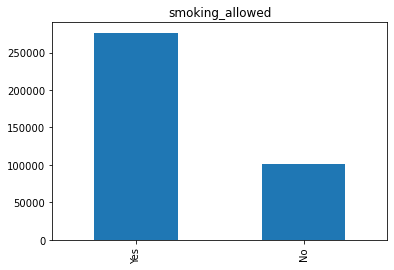

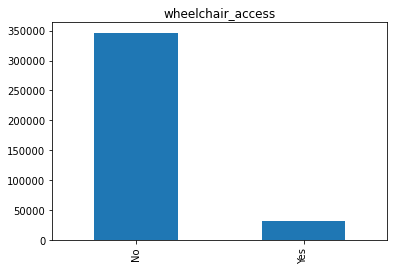

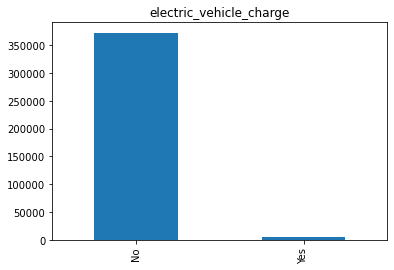

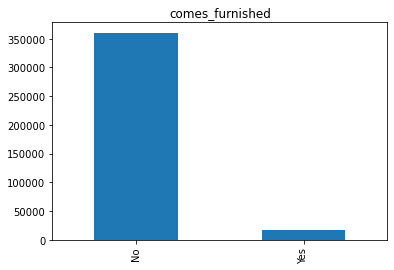

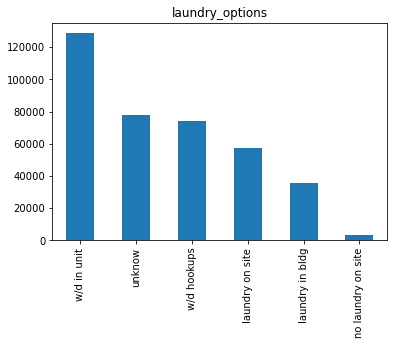

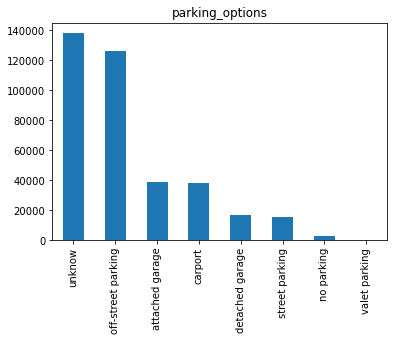

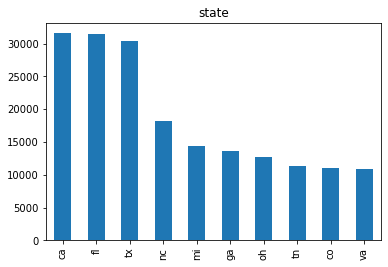

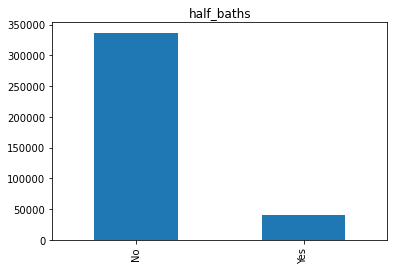

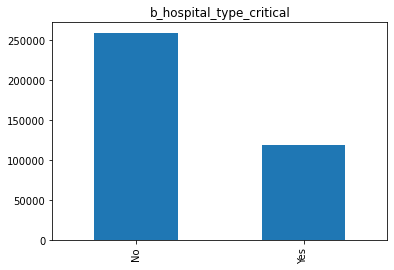

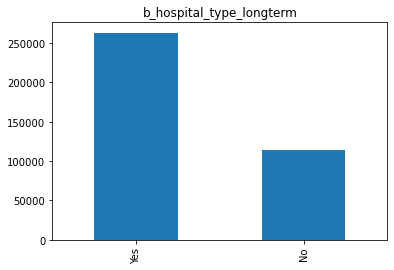

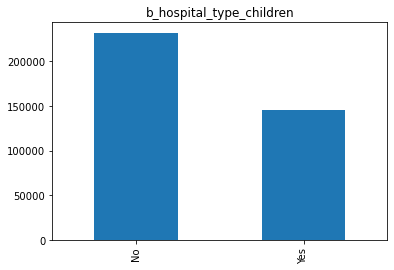

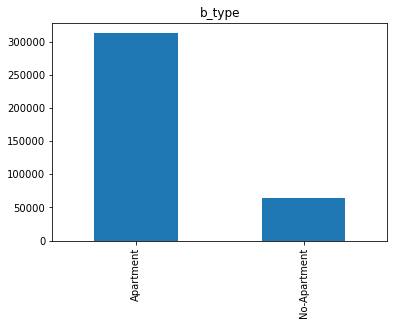

In [289]:
barplot(df)

## Test Script

In [2]:
from feature_generation import preprocessing
preprocessing(data="sandbox", target="price",
                    drop_features =["id", "url", "region_url", "image_url", "description"],
                    skip_log=["beds","baths","lat","long"],
                    skip_outliers=["lat","long"])

price
sqfeet
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school
price
sqfeet
beds
baths
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school
[IterativeImputer] Completing matrix with shape (377256, 22)
[IterativeImputer] Ending imputation round 1/10, elapsed time 7.41
[IterativeImputer] Change: 21.208330958515702, scaled tolerance: 536.628 
[IterativeImputer] Early stopping criterion reached.


In [6]:
con = duckdb.connect('data/exploitation.db')
con.execute("show tables").fetchall()

[('houses',), ('sandbox',), ('sandbox_preprocessed',)]

In [8]:
df = con.execute("select * from sandbox_preprocessed").df()

In [10]:
df.head().transpose()

,0,1,2,3,4
region,tucson,tucson,tucson,tucson,tucson
price,6.986566,6.852243,6.830874,6.437752,6.401917
type,apartment,apartment,apartment,apartment,apartment
sqfeet,6.165418,6.154858,7.590347,6.781058,6.311735
beds,1.0,1.0,3.0,3.0,1.0
baths,1.0,1.0,2.5,1.0,1.0
cats_allowed,Yes,Yes,Yes,Yes,Yes
dogs_allowed,Yes,Yes,Yes,Yes,Yes
smoking_allowed,Yes,Yes,Yes,Yes,No
wheelchair_access,No,No,No,No,No
